### This notebooks demonstrates the Frank-Wolfe Algorithm on Two Examples

In [404]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

np.random.seed(631)
np.set_printoptions(precision=5, suppress=True)

In [410]:
def generate_data(m, n, s, sigma = 0.1):
    # Generate X from Gaussian distribution
    X = np.random.randn(m, n)

    # Create beta_star with first s entries as 1 and the rest 0
    beta_star = np.zeros(n)
    beta_star[:s] = np.random.uniform(-10, 10, s)

    y = X @ beta_star + sigma * np.random.randn(m)

    return X, y, beta_star

In [411]:
# Evaluate the error
def l2_error(beta, beta_star):
    return np.linalg.norm(beta - beta_star)

In [412]:
def plot_results(iterates, objective_values, beta_opt):
    # Calculate the errors between iterates and beta_opt
    errors = [l2_error(beta_t, beta_opt) for beta_t in iterates]

    # Create Figure 1: Error vs. Iteration
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(errors)
    plt.xlabel('Iteration')
    plt.ylabel(r'Error: $\|\beta_t - \beta^*\|_2$')
    plt.title('Error vs. Iteration')

    # Create Figure 2: Objective Function Value vs. Iteration
    plt.subplot(1, 2, 2)
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(objective_values)
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    plt.title('Objective Function Value vs. Iteration')

    plt.tight_layout()
    plt.show()

In [413]:
m, n, s = 100, 10, 10  # m samples, n features, s sparsity
X, y, beta_star = generate_data(m, n, s, sigma=0)

In [414]:
print(beta_star)

[-2.86126 -1.73925  2.91398  0.80402  2.4516  -2.27951  0.09414  5.37663
 -6.90385  0.41191]


In [415]:
def solve_lasso(lambda_val, X, y):
    m, n = X.shape

    beta_cvx = cp.Variable(n)

    objective = cp.Minimize(cp.norm2(y - X @ beta_cvx)**2)
    constraints = [cp.norm(beta_cvx, 1) <= lambda_val]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    return beta_cvx.value

In [418]:
beta_opt = solve_lasso(10, X, y)

print(f"L1-constrained problem -- Error of Convex optimization from CVXPY: \n{l2_error(beta_star, beta_opt)}")

if l2_error(beta_star, beta_opt) < 0.1:
  print("\nThis method recovers the parameter acurrately.\n")
else:
  print("\nThe error seems a bit large.")

L1-constrained problem -- Error of Convex optimization from CVXPY: 
5.613204955372334

The error seems a bit large.


In [419]:
print(beta_opt)
print(beta_star)

[-0.52266 -0.       0.82542  0.       0.41038 -0.      -0.       3.74937
 -4.49217  0.     ]
[-2.86126 -1.73925  2.91398  0.80402  2.4516  -2.27951  0.09414  5.37663
 -6.90385  0.41191]


In [420]:
# beta_opt = beta_star

L1-constrained problem -- Error of Projected gradient: 
0.0013797671255928513

Projected Gradient recovers the parameter acurrately 



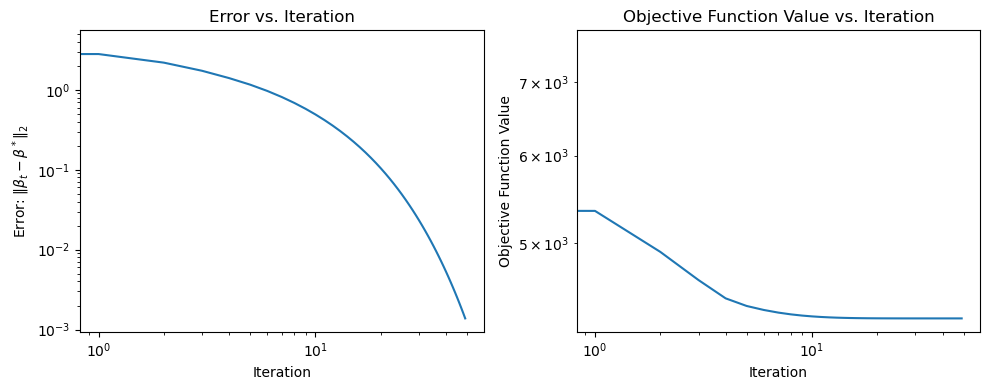

In [421]:
def project_lasso(beta, lambda_val):
    beta_proj = cp.Variable(n)

    objective = cp.Minimize(cp.norm2(beta - beta_proj)**2)
    constraints = [cp.norm1(beta_proj) <= lambda_val]

    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return beta_proj.value


def projected_gradient_lasso(beta_0, X, y, alpha, lambda_, N_iter):
    # Initialize variables
    beta = beta_0
    objective_values = []  # To store the sequence of objective values
    iterates = []  # To store the sequence of iterates (beta values)

    for _ in range(N_iter):
        # Compute the gradient of the objective function
        gradient = -2 * X.T.dot(y - X.dot(beta))

        # Update beta using projection of (beta - alpha * gradient)
        beta = project_lasso(beta - alpha * gradient, lambda_)
        
        # Calculate the objective value and append to the list
        objective_value = np.linalg.norm(y - X.dot(beta))**2
        objective_values.append(objective_value)

        # Append the current iterate (beta) to the list
        iterates.append(beta)

    return beta, iterates, objective_values


## Now let's test projected gradient

# initialization
beta_init = np.zeros(n)
lambda_ = 10
stepsize = 0.001
N_iter = 50

beta_proj, beta_proj_seq, func_proj_seq = projected_gradient_lasso(beta_init, X, y, stepsize, lambda_, N_iter)

print(f"L1-constrained problem -- Error of Projected gradient: \n{l2_error(beta_proj, beta_opt)}\n")

if l2_error(beta_proj, beta_opt) < 0.1:
  print("Projected Gradient recovers the parameter acurrately \n")
else:
  print("The error seems a bit large.\n")

# generate plots
plot_results(beta_proj_seq, func_proj_seq, beta_opt)

In [422]:
print(beta_proj)
print(beta_opt)

[-0.52212 -0.       0.82634  0.       0.41093 -0.      -0.       3.74898
 -4.49163  0.     ]
[-0.52266 -0.       0.82542  0.       0.41038 -0.      -0.       3.74937
 -4.49217  0.     ]


### Frank-Wolfe Method

In [423]:
# Compute the suboptimality of the current iterate
def lasso_subopt(beta, beta_opt, X, y):
    return np.linalg.norm(X @ beta - y)**2 - np.linalg.norm(X @ beta_opt - y)**2

# Compute the target point for Frank-Wolfe
def update_direction_lasso(grad, lambda_):
    # Your code here
    target = cp.Variable(len(grad))

    objective = cp.Minimize(target @ grad)
    constraints = [cp.norm1(target) <= lambda_]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    return target.value

# Compute adaptive (short-step) stepsize for Frank-Wolfe 
def adapt_alpha(beta, grad, target, L):
    alpha = np.dot(grad, beta - target) / (L * np.linalg.norm(beta - target)**2)
    # alpha = grad.dot(beta - target) / (L * (2*lambda_)**2)
    assert alpha.ndim == 0
    return np.min([alpha, 1])

In [424]:
L = np.max(np.linalg.eigvals(X.T.dot(X)))
print(L)
print(np.sort(np.linalg.eigvals(X.T.dot(X)))[::-1])

162.47217165849366
[162.47217 148.55197 141.52601 108.80567 102.14805  87.94579  73.34786
  66.64045  58.48279  56.14396]


In [425]:
def frank_wolfe_lasso(beta_0, X, y, alpha, lambda_, N_iter, const_step=True, 
                      beta_opt=None, epsilon=None, adapt=False):
    if beta_opt is None:
        assert epsilon is None

    if adapt:
        assert const_step is False
        L = 2 * np.max(np.linalg.eigvals(X.T.dot(X)))

    beta = beta_0
    objective_values = []  # To store the sequence of objective values
    iterates = []  # To store the sequence of iterates (beta values)

    # We will compute the suboptimality at each iteration
    if beta_opt is not None:
        subopt = lasso_subopt(beta, beta_opt, X, y)
        subopt_list = []
        mark = int(np.floor(np.log10(subopt)))

    # If beta_opt is not given, we will run N_iter iterations
    if N_iter is not None:
        for i in range(N_iter):
            if beta_opt is not None:
                if subopt < 10 ** mark:
                    print(f"Suboptimality is {subopt:.2e} at step {i}")
                    mark -= 1

            # Compute the gradient of the objective function
            gradient = -2 * X.T.dot(y - X.dot(beta))

            # Update direction
            target = update_direction_lasso(gradient, lambda_)
            
            if not const_step:
                if not adapt:
                    alpha = 2 / (i + 3)
                else:
                    alpha = adapt_alpha(beta, gradient, target, L)
                    
            beta = (1-alpha) * beta + alpha * target
            
            if beta_opt is not None:
                subopt = lasso_subopt(beta, beta_opt, X, y)
                subopt_list.append(subopt)

            # Calculate the objective value and append to the list
            objective_value = np.linalg.norm(y - X.dot(beta))**2
            objective_values.append(objective_value)

            # Append the current iterate (beta) to the list
            iterates.append(beta)

        return beta, iterates, objective_values, subopt_list

    # If beta_opt is given, we will run until the suboptimality is smaller than epsilon
    step = 0
    while  subopt > epsilon:
        # Print the suboptimality when it gets down to the next power of 10 level
        if subopt < 10 ** mark:
            print(f"Suboptimality is {subopt:.2e} at step {step}")
            mark -= 1

        step += 1
        # Compute the gradient of the objective function
        gradient = -2 * X.T.dot(y - X.dot(beta))

        # Update direction
        target = update_direction_lasso(gradient, lambda_)
        
        if not const_step:
            if not adapt:
                alpha = 2 / (step + 2)
            else:
                alpha = adapt_alpha(beta, gradient, target, L)
                
        beta = (1-alpha) * beta + alpha * target
        subopt = lasso_subopt(beta, beta_opt, X, y)
        subopt_list.append(subopt)

        # Calculate the objective value and append to the list
        objective_value = np.linalg.norm(y - X.dot(beta))**2
        objective_values.append(objective_value)

        # Append the current iterate (beta) to the list
        iterates.append(beta)

    return beta, iterates, objective_values, subopt_list

Suboptimality is 9.99e+03 at step 37
L1-constrained problem -- Error of Frank-Wolfe: 
5.586996218179594

The error seems a bit large.



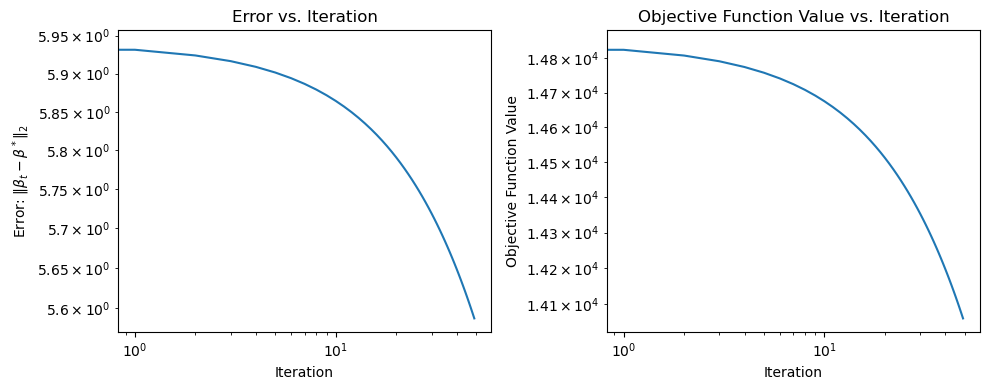

[-0.      -0.       0.       0.       0.      -0.      -0.       0.
 -0.48794  0.     ]


In [426]:
# Test Frank-Wolfe with constant step size

# initialization
beta_init = np.zeros(n)
lambda_ = 10
stepsize = 0.001
N_iter = 50

beta_fw, beta_fw_seq, fun_fw_seq, _ = frank_wolfe_lasso(beta_init, X, y, stepsize, 
                                                     lambda_, N_iter, const_step=True, beta_opt=beta_opt)

print(f"L1-constrained problem -- Error of Frank-Wolfe: \n{l2_error(beta_fw, beta_opt)}\n")

if l2_error(beta_fw, beta_opt) < 0.1:
  print("Frank-Wolfe recovers the parameter acurrately \n")
else:
  print("The error seems a bit large.\n")

# generate plots
plot_results(beta_fw_seq, fun_fw_seq, beta_opt)
print(beta_fw)

Suboptimality is 3.94e+03 at step 1
Suboptimality is 4.45e+02 at step 6
Suboptimality is 9.99e+01 at step 14
Suboptimality is 8.41e+00 at step 45
L1-constrained problem -- Error of Frank-Wolfe: 
0.31388878580494795

The error seems a bit large.



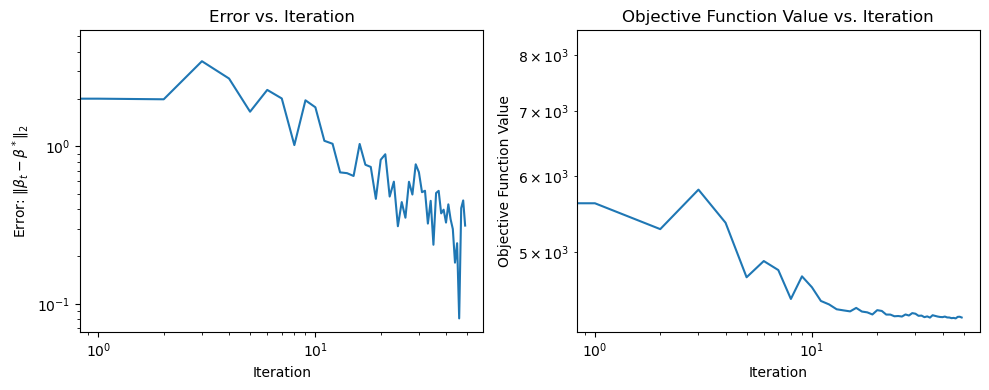

[-0.4902  -0.       0.73906  0.       0.68627 -0.      -0.       3.68024
 -4.39668  0.     ]


In [427]:
# Test Frank-Wolfe with 2/(t+2) step size

# initialization
beta_init = np.zeros(n)
stepsize = None
lambda_ = 10
N_iter = 50

beta_fw, beta_fw_seq, fun_fw_seq, subopt_list = frank_wolfe_lasso(beta_init, X, y, stepsize, 
                                                     lambda_, N_iter, const_step=False, beta_opt=beta_opt)

print(f"L1-constrained problem -- Error of Frank-Wolfe: \n{l2_error(beta_fw, beta_opt)}\n")

if l2_error(beta_fw, beta_opt) < 0.1:
  print("Frank-Wolfe recovers the parameter acurrately \n")
else:
  print("The error seems a bit large.\n")

# generate plots
plot_results(beta_fw_seq, fun_fw_seq, beta_opt)
print(beta_fw)

Suboptimality is 4.63e+03 at step 1
Suboptimality is 9.75e+02 at step 10
L1-constrained problem -- Error of Frank-Wolfe: 
0.2083796940734631

The error seems a bit large.



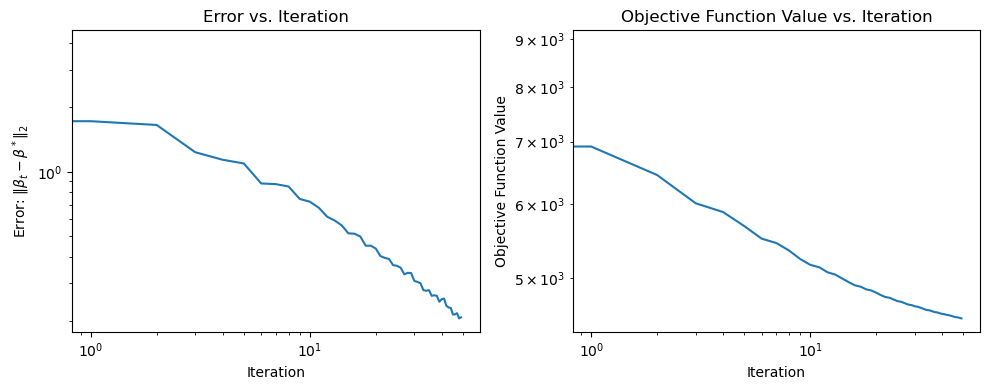

[-0.42052 -0.       0.75463  0.       0.29089 -0.      -0.       3.74673
 -4.37514  0.     ]


In [428]:
# Test Frank-Wolfe with adaptive step size

# initialization
beta_init = np.zeros(n)
lambda_ = 10
stepsize = None
N_iter = 50

beta_fw, beta_fw_seq, fun_fw_seq, _ = frank_wolfe_lasso(beta_init, X, y, stepsize, 
                                                     lambda_, N_iter, const_step=False, 
                                                     beta_opt=beta_opt, adapt=True)

print(f"L1-constrained problem -- Error of Frank-Wolfe: \n{l2_error(beta_fw, beta_opt)}\n")

if l2_error(beta_fw, beta_opt) < 0.1:
  print("Frank-Wolfe recovers the parameter acurrately \n")
else:
  print("The error seems a bit large.\n")

# generate plots
plot_results(beta_fw_seq, fun_fw_seq, beta_opt)
print(beta_fw)

Suboptimality is 3.94e+03 at step 1
Suboptimality is 4.45e+02 at step 6
Suboptimality is 9.99e+01 at step 14
Suboptimality is 8.41e+00 at step 45
Suboptimality is 9.87e-01 at step 128
Suboptimality is 9.20e-02 at step 371
L1-constrained problem -- Error of Frank-Wolfe: 
0.025323026052626908

Frank-Wolfe recovers the parameter acurrately.



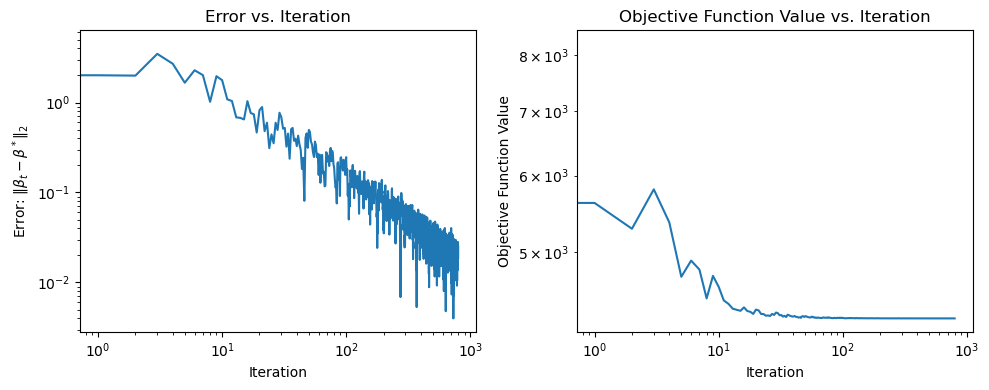

[-0.53207 -0.       0.83686  0.       0.417   -0.      -0.       3.7357
 -4.47835  0.     ]


In [429]:
# Test Frank-Wolfe with 2/(t+2) step size

# initialization
beta_init = np.zeros(n)
lambda_ = 10
stepsize = None
N_iter = 800

beta_fw, beta_fw_seq, fun_fw_seq, subopt_list = frank_wolfe_lasso(beta_init, X, y, stepsize, 
                                                     lambda_, N_iter, const_step=False,
                                                     beta_opt=beta_opt)

print(f"L1-constrained problem -- Error of Frank-Wolfe: \n{l2_error(beta_fw, beta_opt)}\n")

if l2_error(beta_fw, beta_opt) < 0.1:
  print("Frank-Wolfe recovers the parameter acurrately.\n")
else:
  print("The error seems a bit large.\n")

# generate plots
plot_results(beta_fw_seq, fun_fw_seq, beta_opt)
print(beta_fw)

In [430]:
print(f"{np.linalg.norm(X @ beta_opt - y)**2:.10e}")

4.2670620065e+03


Suboptimality is 4.63e+03 at step 1
Suboptimality is 9.75e+02 at step 10
Suboptimality is 9.93e+01 at step 144
L1-constrained problem -- Error of Frank-Wolfe: 
0.015750769776293586


Frank-Wolfe recovers the parameter acurrately 



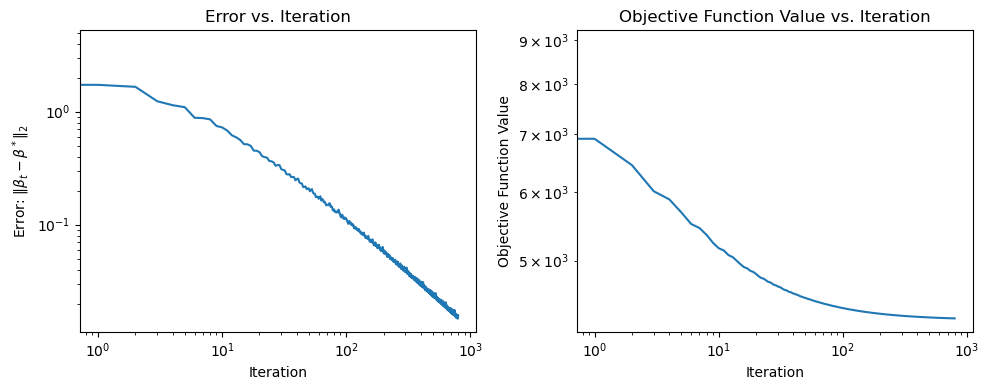

[-0.51325 -0.       0.82286  0.       0.40593 -0.      -0.       3.74677
 -4.48093  0.     ]


In [437]:
# Test Frank-Wolfe with adaptive step size

# initialization
beta_init = np.zeros(n)
lambda_ = 10
stepsize = None
N_iter = 800

beta_fw, beta_fw_seq, fun_fw_seq, _ = frank_wolfe_lasso(beta_init, X, y, stepsize, 
                                                        lambda_, N_iter, const_step=False, 
                                                        beta_opt=beta_opt, adapt=True)

print(f"L1-constrained problem -- Error of Frank-Wolfe: \n{l2_error(beta_fw, beta_opt)}\n")

if l2_error(beta_fw, beta_opt) < 0.1:
  print("\nFrank-Wolfe recovers the parameter acurrately \n")
else:
  print("\nThe error seems a bit large.")

# generate plots
plot_results(beta_fw_seq, fun_fw_seq, beta_opt)
print(beta_fw)

Suboptimality is 3.94e+03 at step 1
Suboptimality is 4.45e+02 at step 6
Suboptimality is 9.99e+01 at step 14
Suboptimality is 8.41e+00 at step 45
Suboptimality is 9.87e-01 at step 128
Suboptimality is 9.20e-02 at step 371
Suboptimality is 9.89e-03 at step 1191
Suboptimality is 9.43e-04 at step 3651
L1-constrained problem -- Error of Frank-Wolfe: 
0.00039019748815224086


Frank-Wolfe recovers the parameter acurrately 



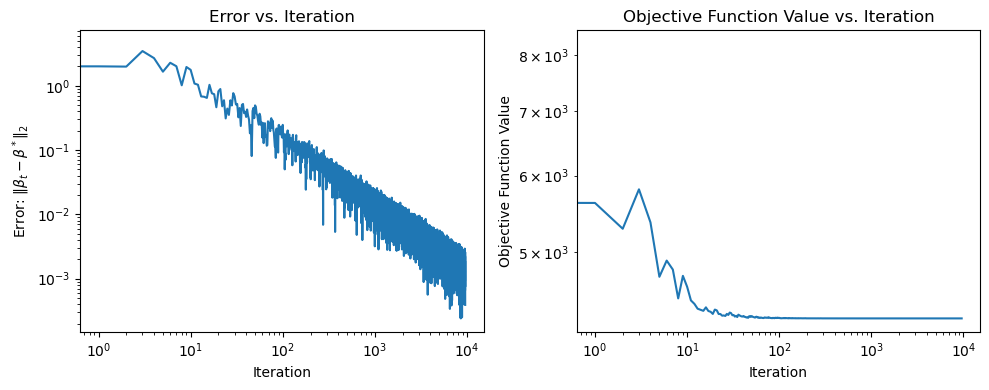

[-0.52269 -0.       0.82517  0.       0.41067 -0.      -0.       3.74937
 -4.4921   0.     ]


In [438]:
## Now test Frank-Wolfe convergence rate with 2/(t+2) step size

# initialization
beta_init = np.zeros(n)
lambda_ = 10
stepsize = None
N_iter = None

beta_fw, beta_fw_seq, fun_fw_seq, subopt_list = frank_wolfe_lasso(beta_init, X, y, stepsize, 
                                                     lambda_, N_iter, const_step=False,
                                                     beta_opt=beta_opt, epsilon=1e-4)

print(f"L1-constrained problem -- Error of Frank-Wolfe: \n{l2_error(beta_fw, beta_opt)}\n")

if l2_error(beta_fw, beta_opt) < 0.1:
  print("\nFrank-Wolfe recovers the parameter acurrately \n")
else:
  print("\nThe error seems a bit large.")

# generate plots
plot_results(beta_fw_seq, fun_fw_seq, beta_opt)
print(beta_fw)

In [433]:
print(len(beta_fw_seq))

9562


Suboptimality is 4.63e+03 at step 1
Suboptimality is 9.75e+02 at step 10
Suboptimality is 9.93e+01 at step 144
Suboptimality is 1.00e+01 at step 1522
L1-constrained problem -- Error of Frank-Wolfe: 
0.001292676642690607

Frank-Wolfe recovers the parameter acurrately 



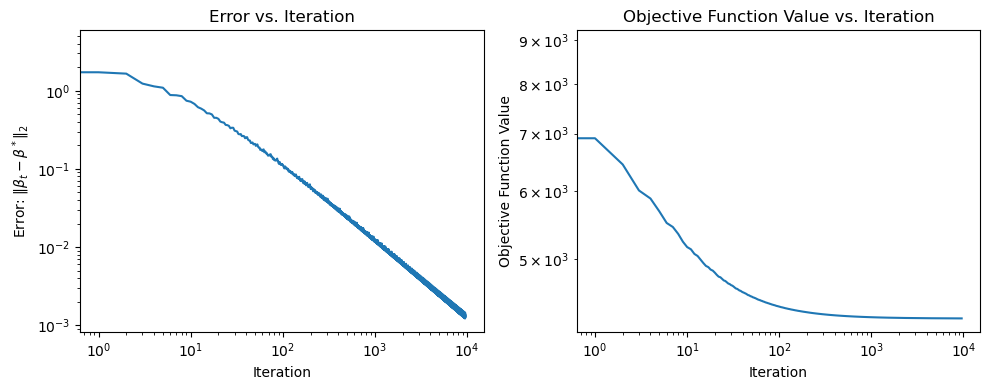

[-0.52219 -0.       0.8245   0.       0.40996 -0.      -0.       3.74872
 -4.49205  0.     ]


In [439]:
## Now test Frank-Wolfe convergence rate with adaptive step size

# initialization
beta_init = np.zeros(n)
lambda_ = 10
stepsize = None
N_iter = len(beta_fw_seq)

beta_fw_a, beta_fw_seq_a, fun_fw_seq_a, subopt_list_a = frank_wolfe_lasso(beta_init, X, y,
                                                          stepsize, lambda_, N_iter, const_step=False, beta_opt=beta_opt, epsilon=1e-4, adapt=True)
subopt_list_a = np.array([lasso_subopt(beta, beta_opt, X, y) for beta in beta_fw_seq_a])
print(f"L1-constrained problem -- Error of Frank-Wolfe: \n{l2_error(beta_fw_a, beta_opt)}\n")

if l2_error(beta_fw_a, beta_opt) < 0.1:
  print("Frank-Wolfe recovers the parameter acurrately \n")
else:
  print("The error seems a bit large.\n")

# generate plots
plot_results(beta_fw_seq_a, fun_fw_seq_a, beta_opt)
print(beta_fw_a)

In [440]:
eigenvalues, _ = np.linalg.eig(X.T @ X)
print(np.sort(eigenvalues)[::-1][:20])
L1 = np.max(eigenvalues)
print(L1)
assert L == L1

diam = 2 * lambda_
c1 = 2 * L * diam**2
print(c1)

[162.47217 148.55197 141.52601 108.80567 102.14805  87.94579  73.34786
  66.64045  58.48279  56.14396]
162.47217165849366
129977.73732679493


In [441]:
print(len(subopt_list))
print(len(subopt_list_a))

9562
9562


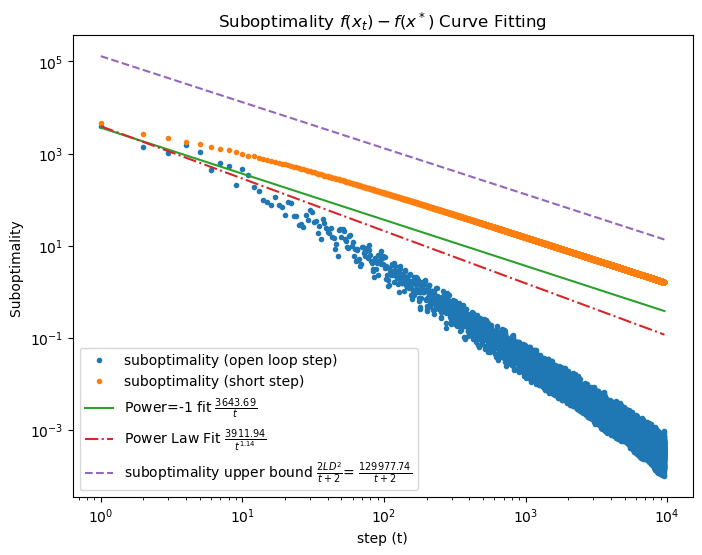

In [443]:
from scipy.optimize import curve_fit

# Define the function to fit (c / i)
def fit_function(i, c):
    return c / i

# Define the power-law fit function (c2 / i^p2)
def power_law_fit(i, c2, p2):
    return c2 / np.power(i, p2)

# Generate the index array (starting from 1)
indices = np.arange(1, len(subopt_list)+1)

# Perform the curve fitting for (c / i)
popt, _ = curve_fit(fit_function, indices, subopt_list)
c_fitted = popt[0]
fitted_values = c_fitted / indices

# Perform the curve fitting for c2/i^p2
popt_power_law, _ = curve_fit(power_law_fit, indices, subopt_list)
c2_fitted, p2_fitted = popt_power_law
power_law_values = c2_fitted / np.power(indices, p2_fitted)


# Generate values for the curve c1/i
c1_values = c1 / indices

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(indices, subopt_list, '.', label='suboptimality (open loop step)')
plt.plot(indices, subopt_list_a, '.', label='suboptimality (short step)')
plt.plot(indices, fitted_values, '-', label=rf'Power=-1 fit $\frac{{{c_fitted:.2f}}}{{t}}$')
plt.plot(indices, power_law_values, '-.', label=rf'Power Law Fit $\frac{{{c2_fitted:.2f}}}{{t^{{ {p2_fitted:.2f}}}}}$')

plt.plot(indices, c1_values, '--', label=r'suboptimality upper bound $\frac{2LD^2}{t+2}$'
         +rf'= $\frac{{{(2*L*diam**2):.2f}}}{{t+2}}$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('step (t)')
plt.ylabel('Suboptimality ')
plt.title(r'Suboptimality $f(x_t) - f(x^*)$ Curve Fitting')
plt.legend(loc='best')
plt.show()

In [445]:
print(beta_opt)
print(np.linalg.norm(beta_opt, 1))

[-0.52266 -0.       0.82542  0.       0.41038 -0.      -0.       3.74937
 -4.49217  0.     ]
9.999999928082847


In [177]:
def create_invertible_matrix(dim):
    while True:
        matrix = np.random.rand(dim, dim)
        if np.linalg.det(matrix) != 0:
            return matrix
    
def create_orthogonal_matrix(dim):
    while True:
        try:
            matrix = np.random.rand(dim, dim)
            return np.linalg.qr(matrix)[0]
        except:
            continue

def is_symmetric(matrix):
    if (matrix.ndim != 2) or (matrix.shape[0] != matrix.shape[1]):
        return False
    return np.allclose(matrix, matrix.T)

In [179]:
# Create a matrix A with nonnegative eigenvalues
dim = 10
D = np.diag(np.arange(1, dim+1))
P = create_orthogonal_matrix(dim)
A = P @ D @ P.T

In [180]:
print(is_symmetric(A))
eigenvalues, _ = np.linalg.eig(A)
print(eigenvalues)

True
[ 1. 10.  2.  9.  3.  4.  8.  5.  6.  7.]


In [181]:
b = np.random.rand(dim)
print(b)

[0.60301 0.54229 0.48844 0.03736 0.73964 0.29755 0.58474 0.31109 0.64285
 0.39698]


In [182]:
def quadratic_min(A, b, lambda_):
    assert A.ndim == 2
    assert b.ndim == 1
    assert A.shape[0] == A.shape[1] == len(b)

    x = cp.Variable(len(b))

    objective = cp.Minimize(0.5 * cp.quad_form(x, A) + b.T @ x)
    constraints = [cp.norm1(x) <= lambda_]

    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return x.value

In [191]:
lambda_ = 0.1
x_opt = quadratic_min(A, b, lambda_)
print(x_opt)

x_opt_unconstrained = -np.linalg.inv(A) @ b
print(x_opt_unconstrained)

[-0.02439 -0.01639 -0.00242  0.      -0.03722  0.      -0.01056  0.
 -0.00902  0.     ]
[-0.66555 -0.55253 -0.56087 -0.36035 -0.4476  -0.25771 -0.39766 -0.30945
 -0.28019 -0.16115]
